In [1]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import os
import pickle
import xarray
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy
import datetime
from ll_xy import lonlat_to_xy
import matplotlib.pyplot as plt
import kuka_tools as kt
from scipy.stats import binned_statistic


In [2]:
dir = '../../data/rothera/20230901'

In [3]:
listfiles = os.listdir(dir)
listfiles

ku_files = sorted([f for f in listfiles if 'Ka-Scat' in f])

ku_files

['kuka_stare_decon_Ka-Scat20230901-184721.nc',
 'kuka_stare_decon_Ka-Scat20230901-185221.nc',
 'kuka_stare_decon_Ka-Scat20230901-185721.nc']

1154
251
4


Text(0, 0.5, 'y distance (m)')

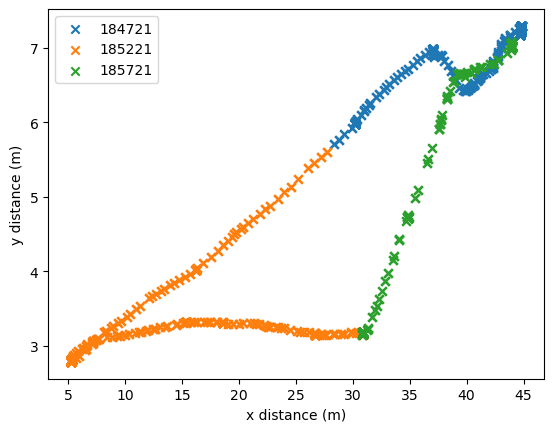

In [4]:

x,y=kt.plot_pos(ku_files[0],dir,plot=False)

x0 = -2300414.994491106; y0 = 923485.871699531

xy_dict = {}

for f in ku_files:

    x,y = kt.plot_pos(f,dir,x0=x0,y0=y0)

    print(np.argmin(x))

    xy_dict[f] = (x,y)
    
plt.legend()
plt.xlabel('x distance (m)')
plt.ylabel('y distance (m)')


1154


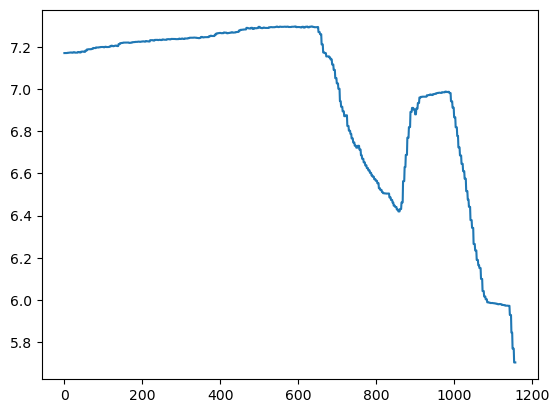

251


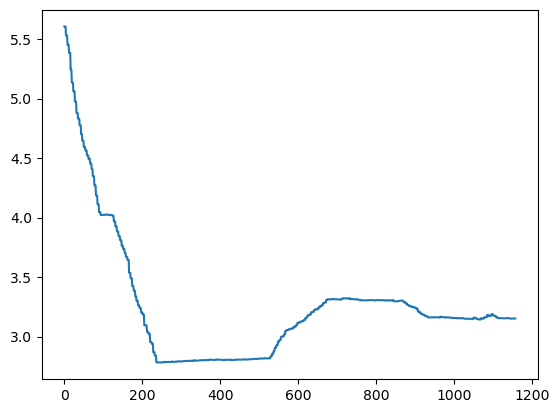

In [12]:
for f in ku_files[0:2]:
    x,y = xy_dict[f]
    print(np.argmin(x))
    plt.plot(y)
    plt.show()
# plt.xlim(580,610)    

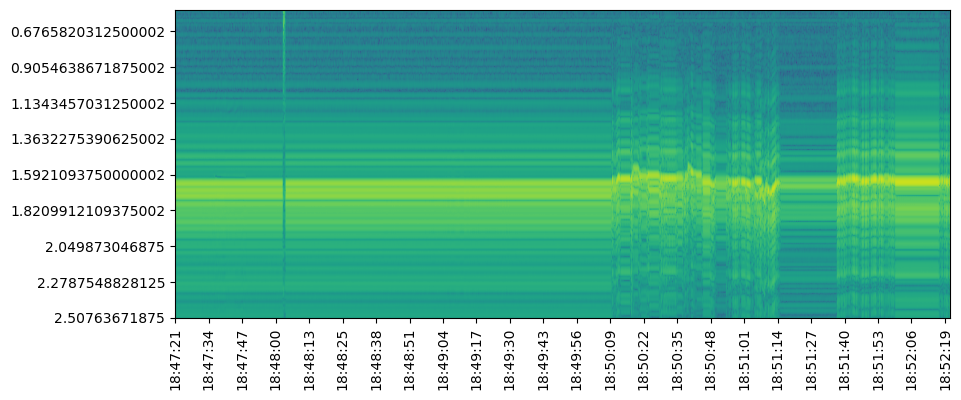

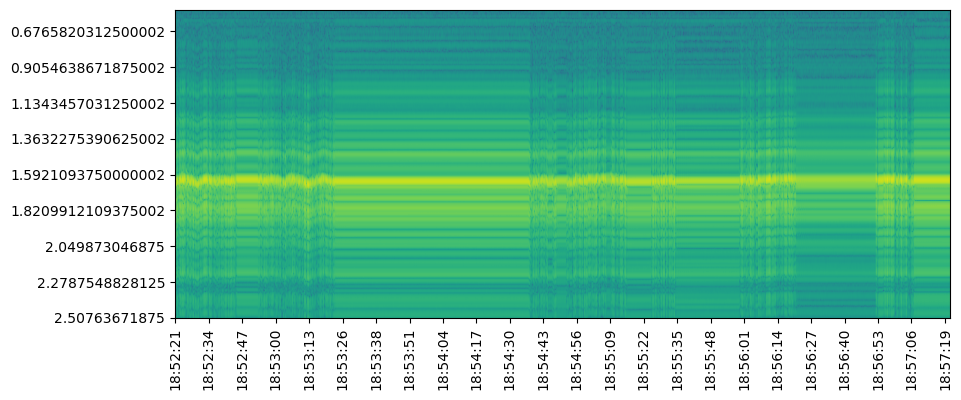

In [13]:
for f in ku_files[0:2]:
    kt.plot_file(f,'ka',dir)
    

In [14]:
foi = ku_files[0]
x,y=xy_dict[foi]
d = Dataset(f'{dir}/{foi}')
d

range = np.array(d['range'])

time_offset_s=0
times = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(x))+datetime.timedelta(seconds=int(time_offset_s)) for x in d['start_time']])

# mintime = kt.get_time_index(datetime.datetime(2023,9,1,18,54,38),times)
# maxtime = kt.get_time_index(datetime.datetime(2023,9,1,18,57,8),times)

mintime=0
maxtime=-1

x_ = 0; y_ = 0

along_track1 = np.sqrt((x-x_)**2 + (y-y_)**2)

nrcs1 = kt.get_nrcs(d,'ka')

In [15]:
foi = ku_files[1]
x,y=xy_dict[foi]
d = Dataset(f'{dir}/{foi}')

range = np.array(d['range'])

time_offset_s=0
times = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(x))+datetime.timedelta(seconds=int(time_offset_s)) for x in d['start_time']])

# mintime = kt.get_time_index(datetime.datetime(2023,9,1,18,54,38),times)
# maxtime = kt.get_time_index(datetime.datetime(2023,9,1,18,57,8),times)

mintime=0
maxtime=132

x_ = 0; y_ = 0

along_track2 = np.sqrt((x-x_)**2 + (y-y_)**2)[mintime:maxtime]


nrcs2 = kt.get_nrcs(d,'ka')

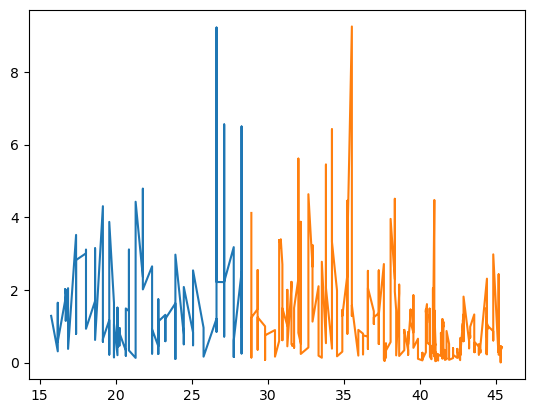

In [16]:
nrcsvv2 = nrcs2['vv'][mintime:maxtime]

plt.plot(along_track2,nrcsvv2)
plt.plot(along_track1,nrcs1['vv'])
# plt.plot(along_track1,np.array(d['cross_tilt']))

# Plot Return Leg

In [26]:
foi = ku_files[1]
d = Dataset(f'{dir}/{foi}')
d

range = np.array(d['range'])

time_offset_s=0
times = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(x))+datetime.timedelta(seconds=int(time_offset_s)) for x in d['start_time']])

# mintime = kt.get_time_index(datetime.datetime(2023,9,1,18,54,38),times)
# maxtime = kt.get_time_index(datetime.datetime(2023,9,1,18,57,8),times)

mintime=251
maxtime=1104

x_ = 0; y_ = 0

along_track = np.sqrt((x-x_)**2 + (y-y_)**2)
xdiff = np.diff(x)
ydiff = np.diff(y)
speed = np.sqrt(np.square(xdiff)+np.square(ydiff))
speed=list(speed)+[0]

nrcs = pd.DataFrame(kt.get_nrcs(d,'ka'))

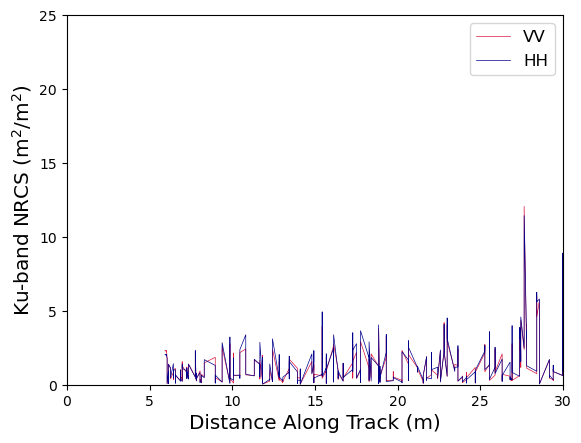

In [27]:
nrcs['along_track']=along_track
nrcs['speed']=speed




nrcs_return = nrcs.iloc[mintime:maxtime]

nrcs_return = nrcs_return.sort_values('along_track').reset_index()

nrcs_return = nrcs_return[nrcs_return['along_track']<30]

plt.plot(nrcs_return['along_track'],
         nrcs_return['vv'],
         label='VV',
         lw=0.5,
         color='crimson')

plt.plot(nrcs_return['along_track'],
         nrcs_return['hh'],
         label='HH',
         lw=0.5,
         color='darkblue')

plt.ylabel('Ku-band NRCS (m$^2$/m$^2$)',fontsize='x-large')
plt.xlabel('Distance Along Track (m)',fontsize='x-large')



# plt.axvspan(start_along_track,end_along_track,color='grey',alpha=0.2)
plt.ylim(0,25)
plt.xlim(0,30)
plt.legend(fontsize='large')
plt.show()

In [29]:
pickle.dump(nrcs_return,open('../../data/pickles/NRCS_901_KA.p','wb'))

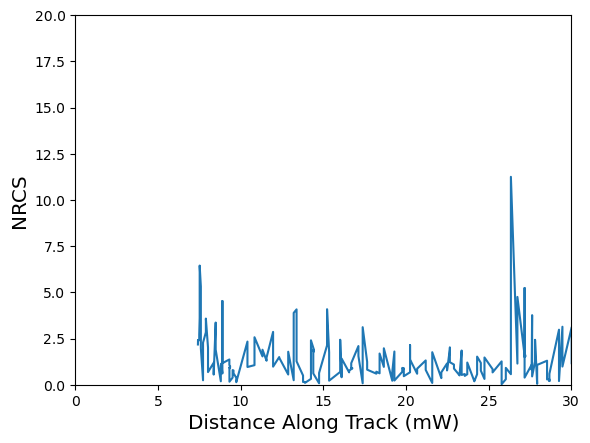

1.2630394865453225


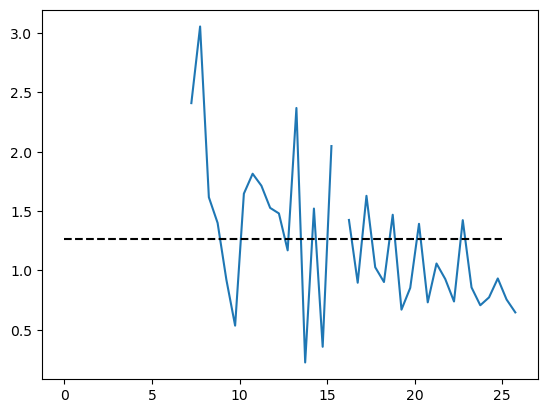

In [50]:
nrcs = pd.DataFrame(kt.get_nrcs(d,'ku'))

# import pickle
# pickle_file = '../data/pickles/901_trans.p'
# pickle.dump( (along_track,nrcs), open(pickle_file,'wb'))

plt.plot(along_track[mintime:maxtime],nrcs['vv'][mintime:maxtime])
bs = binned_statistic(along_track[mintime:maxtime],nrcs['vv'][mintime:maxtime],
                      statistic='mean',bins=np.arange(0,26.1,0.5))

plt.ylabel('NRCS',fontsize='x-large')
plt.xlabel('Distance Along Track (mW)',fontsize='x-large')
plt.ylim(0,20)
plt.xlim(0,30)

plt.show()

bin_centres = np.arange(0.25,26.01,0.5)

plt.plot(bin_centres,bs[0])

thresh=25

mean = np.nanmean(bs[0][bin_centres<thresh])

plt.plot([0,thresh],[mean,mean],color='k',ls='--')

print(mean)

plt.show()